In [ ]:
# Si es la primera vez que utilizas SQLAlchemy y no se encuentra instalado, descomentar e instalar.
# pip install sqlalchemy

In [92]:
import pandas as pd
import sqlalchemy as db
from urllib.error import HTTPError


In [93]:
# Convierto el archivo csv remoto en dataframe | de no existir la ruta abre el archivo que tenemos de respaldo

try:
    df_medallas = pd.read_csv("http://winterolympicsmedals.com/medasls.csv")
except HTTPError:
    df_medallas = pd.read_csv("medals_local.csv")
    



In [94]:
# Verifico que se creo correctamente el dataframe
df_medallas.head()

,Year,City,Sport,Discipline,NOC,Event,Event gender,Medal
0,1924,Chamonix,Skating,Figure skating,AUT,individual,M,Silver
1,1924,Chamonix,Skating,Figure skating,AUT,individual,W,Gold
2,1924,Chamonix,Skating,Figure skating,AUT,pairs,X,Gold
3,1924,Chamonix,Bobsleigh,Bobsleigh,BEL,four-man,M,Bronze
4,1924,Chamonix,Ice Hockey,Ice Hockey,CAN,ice hockey,M,Gold


In [95]:
# Verificamos el formato de los datos para luego realizar el filtrado
df_medallas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          2311 non-null   int64 
 1   City          2311 non-null   object
 2   Sport         2311 non-null   object
 3   Discipline    2311 non-null   object
 4   NOC           2311 non-null   object
 5   Event         2311 non-null   object
 6   Event gender  2311 non-null   object
 7   Medal         2311 non-null   object
dtypes: int64(1), object(7)
memory usage: 144.6+ KB


In [96]:
# Verificamos cuales son los posibles codigos pais para encontrar el que nos interesa
df_medallas['NOC'].unique()

array(['AUT', 'BEL', 'CAN', 'FIN', 'FRA', 'GBR', 'NOR', 'SUI', 'SWE',
       'USA', 'GER', 'TCH', 'HUN', 'ITA', 'FRG', 'NED', 'EUA', 'JPN',
       'POL', 'URS', 'PRK', 'GDR', 'ROU', 'ESP', 'LIE', 'BUL', 'YUG',
       'CHN', 'EUN', 'KOR', 'LUX', 'NZL', 'AUS', 'BLR', 'KAZ', 'RUS',
       'SLO', 'UKR', 'UZB', 'CZE', 'DEN', 'CRO', 'EST', 'LAT', 'SVK'],
      dtype=object)

In [97]:
#Descargar los datos y obtener un sub dataset que contenga
#a todas las medallas de oro (Gold) Estados Unidos (USA) a partir del año 1950.

df_med_usa1950 = df_medallas[ (df_medallas['NOC']=='USA')  & (df_medallas['Year']>=1950)  ]
df_med_usa1950


,Year,City,Sport,Discipline,NOC,Event,Event gender,Medal
307,1952,Oslo,Bobsleigh,Bobsleigh,USA,four-man,M,Silver
308,1952,Oslo,Bobsleigh,Bobsleigh,USA,two-man,M,Silver
309,1952,Oslo,Ice Hockey,Ice Hockey,USA,ice hockey,M,Silver
310,1952,Oslo,Skating,Figure skating,USA,individual,M,Bronze
311,1952,Oslo,Skating,Figure skating,USA,individual,M,Gold
...,...,...,...,...,...,...,...,...
2306,2006,Turin,Skiing,Snowboard,USA,Half-pipe,M,Silver
2307,2006,Turin,Skiing,Snowboard,USA,Half-pipe,W,Gold
2308,2006,Turin,Skiing,Snowboard,USA,Half-pipe,W,Silver
2309,2006,Turin,Skiing,Snowboard,USA,Snowboard Cross,M,Gold


In [98]:
# Creación del engine y de la base de datos de no existir "olympics"
engine = db.create_engine('sqlite:///olympics.db')
sqla_connection = engine.connect()

# Creamos la tabla
query = """CREATE TABLE IF NOT EXISTS medals (
            Year INTEGER,
            City VARCHAR(40),
            Sport VARCHAR(40),
            Discipline VARCHAR(40),
            NOC VARCHAR(3),
            Event VARCHAR(40),
            'Event gender' VARCHAR(1),
            Medal VARCHAR(5)
            );"""
engine.execute(query, con=sqla_connection)


In [99]:
# Insertamos el dataframe a la base de dato
df_med_usa1950.to_sql(name='medals', con=sqla_connection, if_exists='append', index = False)

181

In [100]:
#Controlamos su inserción correcta
check_registros = engine.execute('SELECT * FROM '
                        '"medals" LIMIT 10')

In [101]:
for registro in check_registros:
    print(registro)

(1952, 'Oslo', 'Bobsleigh', 'Bobsleigh', 'USA', 'four-man', 'M', 'Silver')
(1952, 'Oslo', 'Bobsleigh', 'Bobsleigh', 'USA', 'two-man', 'M', 'Silver')
(1952, 'Oslo', 'Ice Hockey', 'Ice Hockey', 'USA', 'ice hockey', 'M', 'Silver')
(1952, 'Oslo', 'Skating', 'Figure skating', 'USA', 'individual', 'M', 'Bronze')
(1952, 'Oslo', 'Skating', 'Figure skating', 'USA', 'individual', 'M', 'Gold')
(1952, 'Oslo', 'Skating', 'Figure skating', 'USA', 'individual', 'W', 'Silver')
(1952, 'Oslo', 'Skating', 'Figure skating', 'USA', 'pairs', 'X', 'Silver')
(1952, 'Oslo', 'Skating', 'Speed skating', 'USA', '500m', 'M', 'Gold')
(1952, 'Oslo', 'Skating', 'Speed skating', 'USA', '500m', 'M', 'Silver')
(1952, 'Oslo', 'Skiing', 'Alpine Skiing', 'USA', 'giant slalom', 'W', 'Gold')


In [102]:
#Controlamos que la información que habiamos insertado cumplia los requisitos
control1 = engine.execute('SELECT MIN(Year) FROM '
                        '"medals" ')
control2 = engine.execute('SELECT DISTINCT(NOC) FROM '
                        '"medals" ')
fecha_minima= [x for x in control1]


paises=[x for x in control2]

try:
    assert(fecha_minima[0][0]>=1952)
except AssertionError:
    print(" ----- LA FECHA NO CUMPLE LOS REQUISITOS ----- ")
    print(f" ----- FECHA: {fecha_minima[0][0]} ----- ")
try:
    assert(paises[0][0]=="USA")
except AssertionError:
    print(" ----- LOS PAISES NO CUMPLE LOS REQUISITOS ----- ")
    print(f" ----- PAISES: {paises[0][0]} ----- ")



Agregamos unas graficas sobre la información descargada de la tabla

Text(0.5, 17.199999999999996, 'Sexo/Medalla')

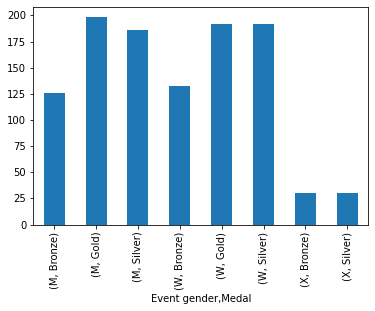

In [103]:
import matplotlib.pyplot as plt


registros = engine.execute('SELECT * FROM '
                        '"medals" ')
df_med_graf = pd.DataFrame(registros.fetchall())

plot_gender=df_med_graf.groupby(['Event gender','Medal'])['Medal'].count().plot.bar()

plot_testdf.set_ylabel("Cantidad de Medallas")
plot_testdf.set_xlabel("Sexo/Medalla")



In [104]:
# Mostramos como quedan los datos agrupados
df_med_graf.groupby(['Event gender','Medal'])['Event gender'].count()


Event gender  Medal 
M             Bronze    126
              Gold      198
              Silver    186
W             Bronze    132
              Gold      192
              Silver    192
X             Bronze     30
              Silver     30
Name: Event gender, dtype: int64

Si queremos descomponer la grafica para una visualización mas ordenada debemos trabajar en los datos, actualmente el groupby nos devuelve una serie por lo que deberemos:
1) Convertirlo en un dataframe

2) Cambiamos el nombre de la Columna que corresponde al total agrupado

3) Convertimos los indices en columnas del dataframe

4) Transponemos una de las columnas 




In [105]:
df_medals_event=pd.DataFrame(df_med_graf.groupby(['Event gender','Medal'])['Event gender'].count())
df_medals_event

Event gender
Event gender Medal               
M            Bronze           126
             Gold             198
             Silver           186
W            Bronze           132
             Gold             192
             Silver           192
X            Bronze            30
             Silver            30

In [106]:
df_medals_event.rename(columns={'Event gender':'Total'}, inplace=True)
df_medals_event

Total
Event gender Medal        
M            Bronze    126
             Gold      198
             Silver    186
W            Bronze    132
             Gold      192
             Silver    192
X            Bronze     30
             Silver     30

In [107]:
df_medals_event.reset_index(inplace=True)
df_medals_event

,Event gender,Medal,Total
0,M,Bronze,126
1,M,Gold,198
2,M,Silver,186
3,W,Bronze,132
4,W,Gold,192
5,W,Silver,192
6,X,Bronze,30
7,X,Silver,30


In [108]:
df_medals_event.pivot(index='Medal', columns='Event gender', values='Total')
df_medals_event

,Event gender,Medal,Total
0,M,Bronze,126
1,M,Gold,198
2,M,Silver,186
3,W,Bronze,132
4,W,Gold,192
5,W,Silver,192
6,X,Bronze,30
7,X,Silver,30


Text(0.5, 1.0, 'Simple Grouped Barplot')

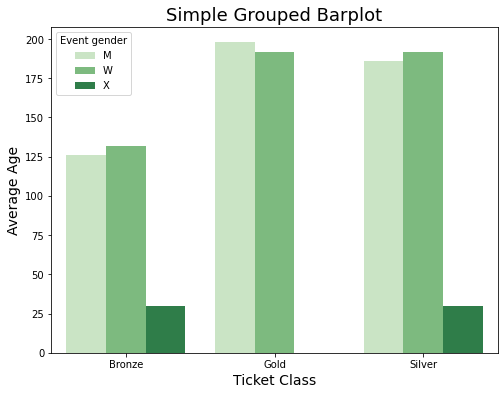

In [120]:
import seaborn as sns 
plt.figure(figsize=(8, 6)) 
sns.barplot(x="Medal", y="Total", 
            hue="Event gender", data=df_medals_event, 
            palette='Greens') 
  
plt.ylabel("Average Age", size=14) 
plt.xlabel("Ticket Class", size=14) 
plt.title("Simple Grouped Barplot", size=18)